# <center> 3.2 - Визуализация. Ошибки модели</center> 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import seaborn as sns; sns.set_theme()

In [2]:
car_info = pd.read_csv('../data/car_info.csv')   # car_info - информация про машины с таргетом
 
rides_info = pd.read_csv('../data/rides_info.csv') # rides_info - информация про поездки

In [3]:
rides_info = rides_info.merge(car_info, on = 'car_id', how = 'left')

In [4]:
drop_cols = ['user_id', 'car_id', 'ride_id', 'ride_date']
cat_cols = ['car_type', 'fuel_type', 'model']

In [5]:
# заполним пропущенные значения медианным значением по столбцу
rides_info.fillna(rides_info.median(), inplace=True)

## Классификация

In [6]:
X = rides_info.drop(drop_cols + ['target_1','target_2'], axis=1)
y = rides_info['target_2']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                         )

In [9]:
clf.fit( X_train, y_train, 
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(clf.get_best_score())

Learning rate set to 0.122678
0:	learn: 2.1237286	test: 2.1235520	best: 2.1235520 (0)	total: 731ms	remaining: 12m 10s
50:	learn: 1.6982674	test: 1.6949019	best: 1.6949019 (50)	total: 28.3s	remaining: 8m 46s
100:	learn: 1.5356870	test: 1.5306926	best: 1.5306926 (100)	total: 55.6s	remaining: 8m 14s
150:	learn: 1.3830165	test: 1.3785888	best: 1.3785888 (150)	total: 1m 23s	remaining: 7m 48s
200:	learn: 1.2569269	test: 1.2519791	best: 1.2519791 (200)	total: 1m 51s	remaining: 7m 21s
250:	learn: 1.1493278	test: 1.1433254	best: 1.1433254 (250)	total: 2m 18s	remaining: 6m 54s
300:	learn: 1.0527961	test: 1.0471525	best: 1.0471525 (300)	total: 2m 46s	remaining: 6m 27s
350:	learn: 0.9675568	test: 0.9622353	best: 0.9622353 (350)	total: 3m 14s	remaining: 5m 59s
400:	learn: 0.8906424	test: 0.8855582	best: 0.8855582 (400)	total: 3m 42s	remaining: 5m 32s
450:	learn: 0.8274750	test: 0.8226257	best: 0.8226257 (450)	total: 4m 10s	remaining: 5m 4s
500:	learn: 0.7660808	test: 0.7614135	best: 0.7614135 (500)

In [16]:
# Посмотрим важность признаков
fi = clf.get_feature_importance(prettified=True)
fi[:30]

Feature Id  Importances
0          car_rating    21.839000
1              riders    20.316344
2               model    17.835348
3        year_to_work    14.091419
4       year_to_start     7.633530
5            car_type     5.702227
6    deviation_normal     3.830842
7           speed_max     2.758168
8          stop_times     2.533771
9   user_ride_quality     1.305708
10             rating     1.270523
11          speed_avg     0.446493
12           distance     0.145785
13          fuel_type     0.129161
14      ride_duration     0.116507
15          ride_cost     0.045173
16          refueling     0.000000

## Визулизируем важность фичей модели из Катбуста

Не стоит сильно доверять этому рейтингу важности, т.к. для сильно скоррелированных признаков импортанс делится пополам и они оба могут улететь вниз по важности.

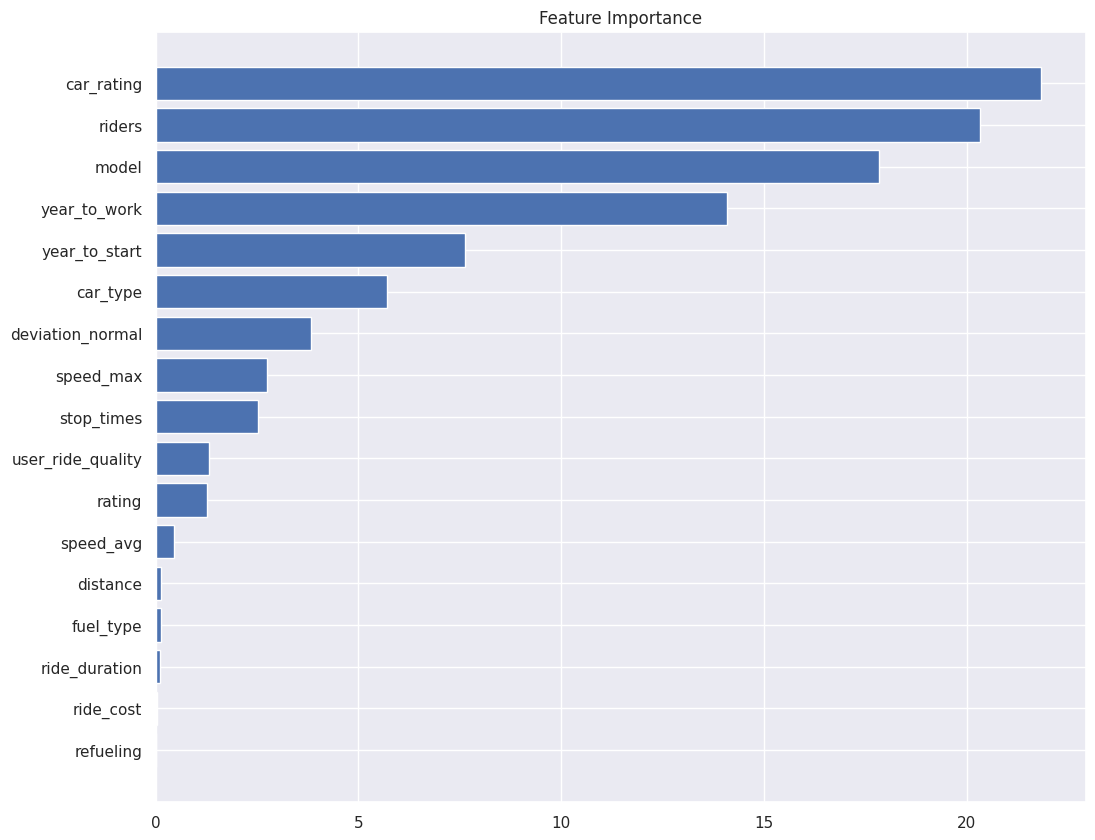

In [24]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

## Посмотрим на графики важности более точных методов

## <center><b> Permutation importance </b></center> 

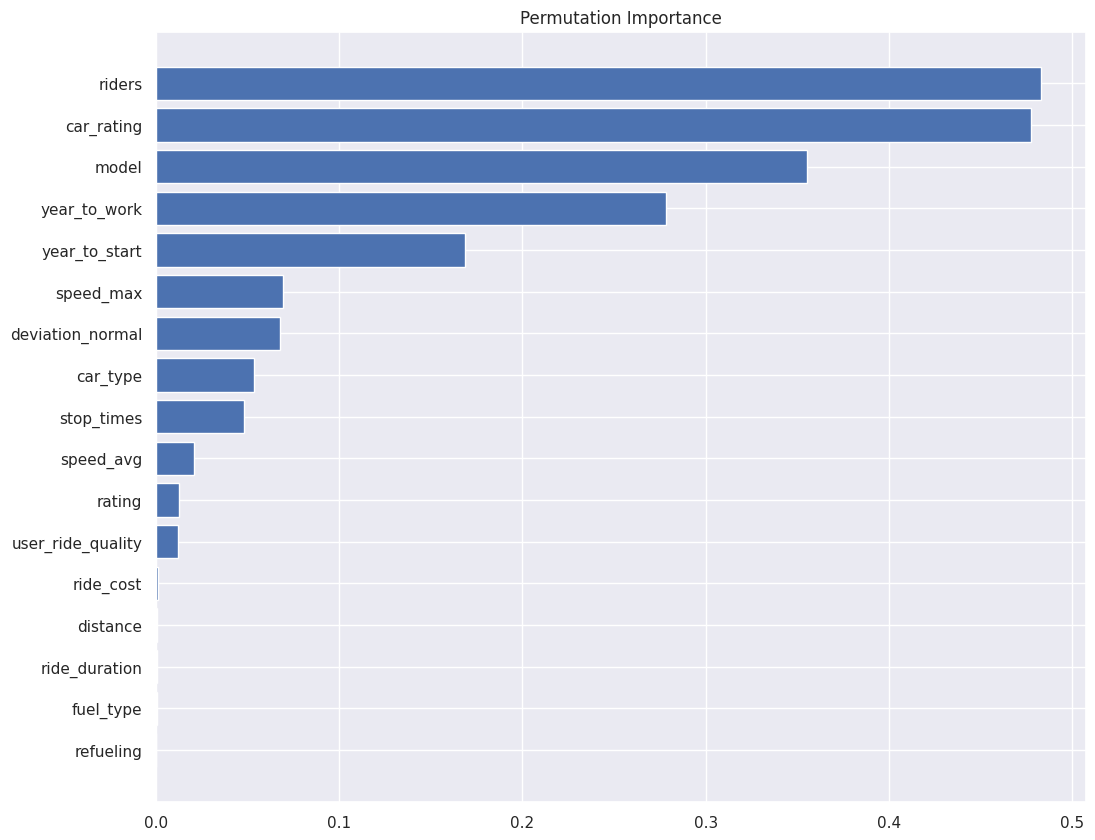

In [26]:
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

## <center><b> SHAP values </b></center> 

<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png">

In [37]:
!pip uninstall opencv-python -y -q
!pip install opencv-python shap -q

In [10]:
import shap
shap.initjs()

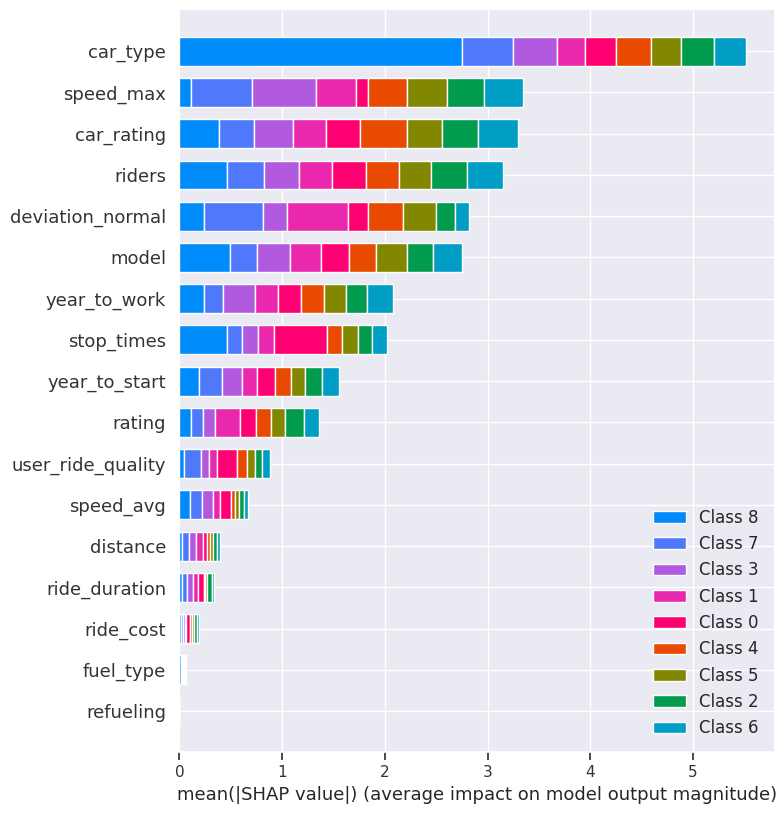

In [11]:
# Можем посмотреть влияние фичей на все классы
explainer = shap.TreeExplainer(clf)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

Class 0


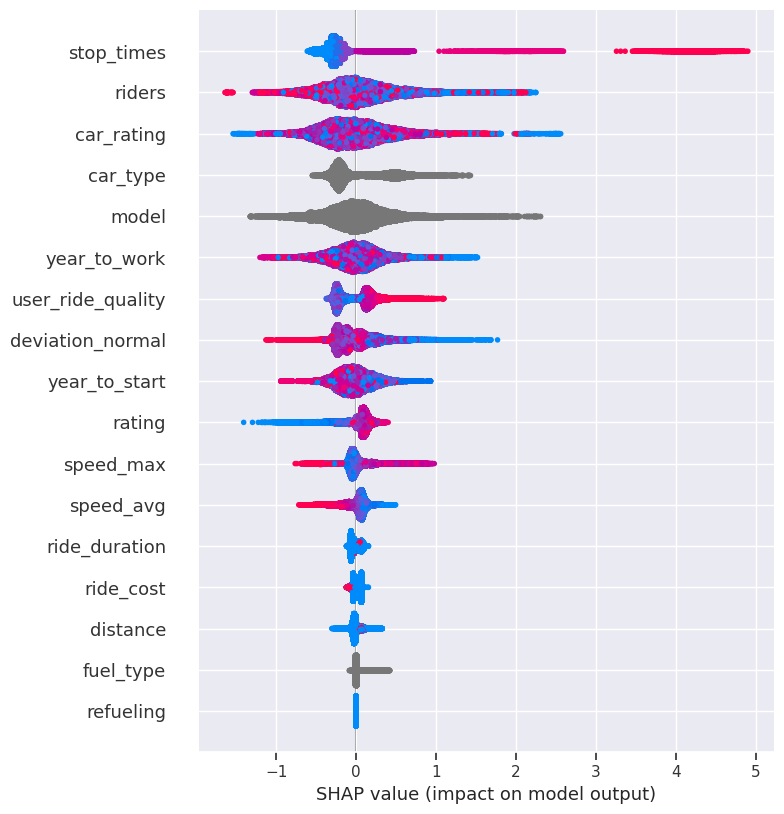

Class 1


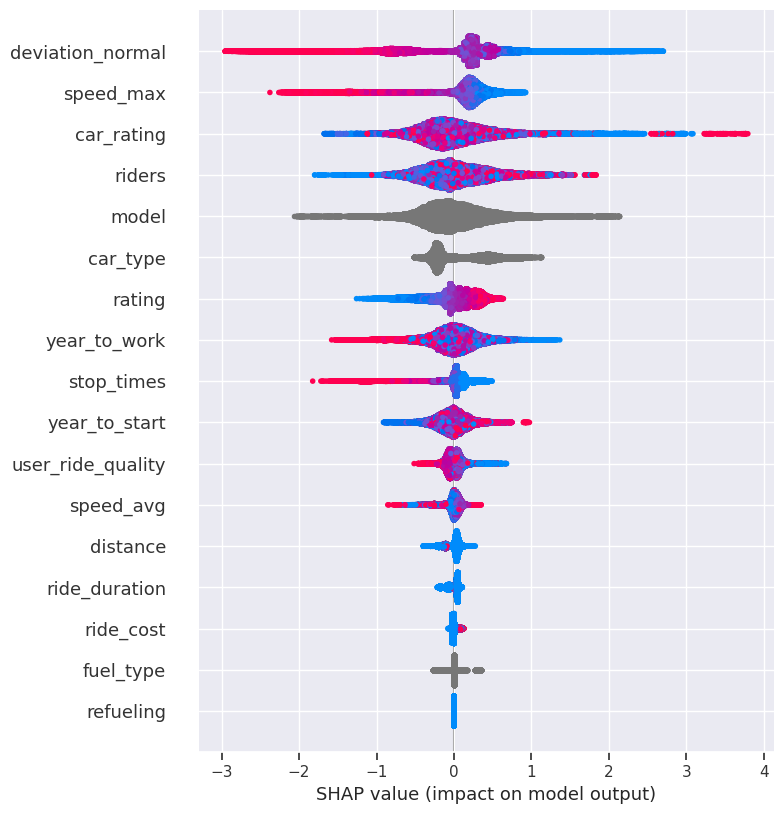

Class 2


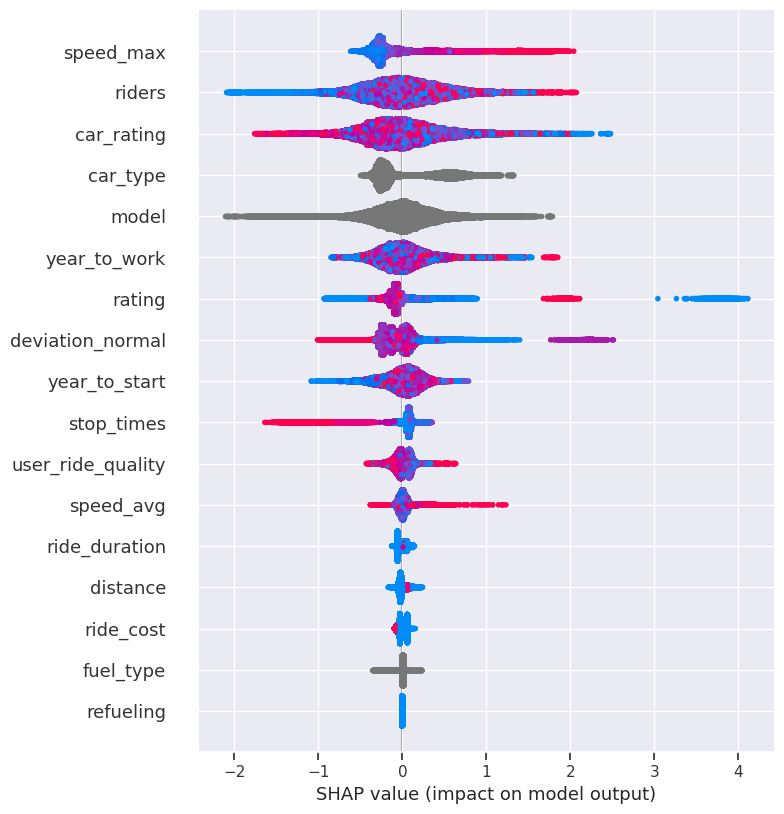

In [24]:
# Или на каждый класс по отдельности
for i in range(len(np.unique(y.values))):
    print(f'Class {i}')
    shap.summary_plot(shap_values[i], X_test, color_bar=False)
    if i == 2:
        break
#shap.summary_plot(shap_values[1], X_test, color_bar=False)

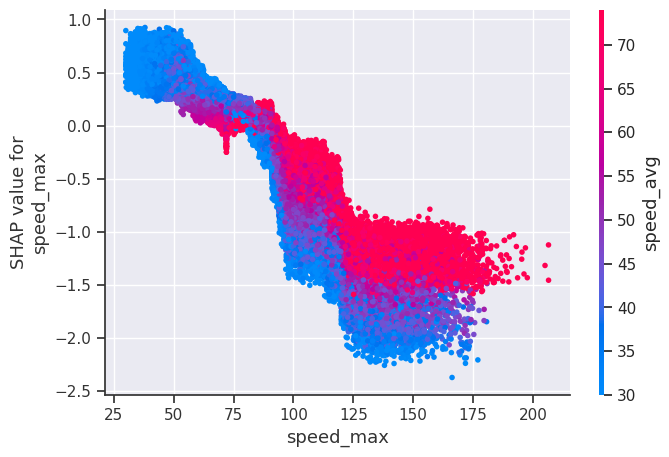

In [25]:
# так же можем посмотреть влияние отдельной фичи на конкретный класс с помощью dependence_plot 
shap.dependence_plot("speed_max", shap_values[1], X_test)

## <center> Матрица смежности </center>

Посмотрим в каких классах модель больше всего ошибается с помощью матрицы смежности

In [33]:
pred = clf.predict(X_test)

<AxesSubplot: >

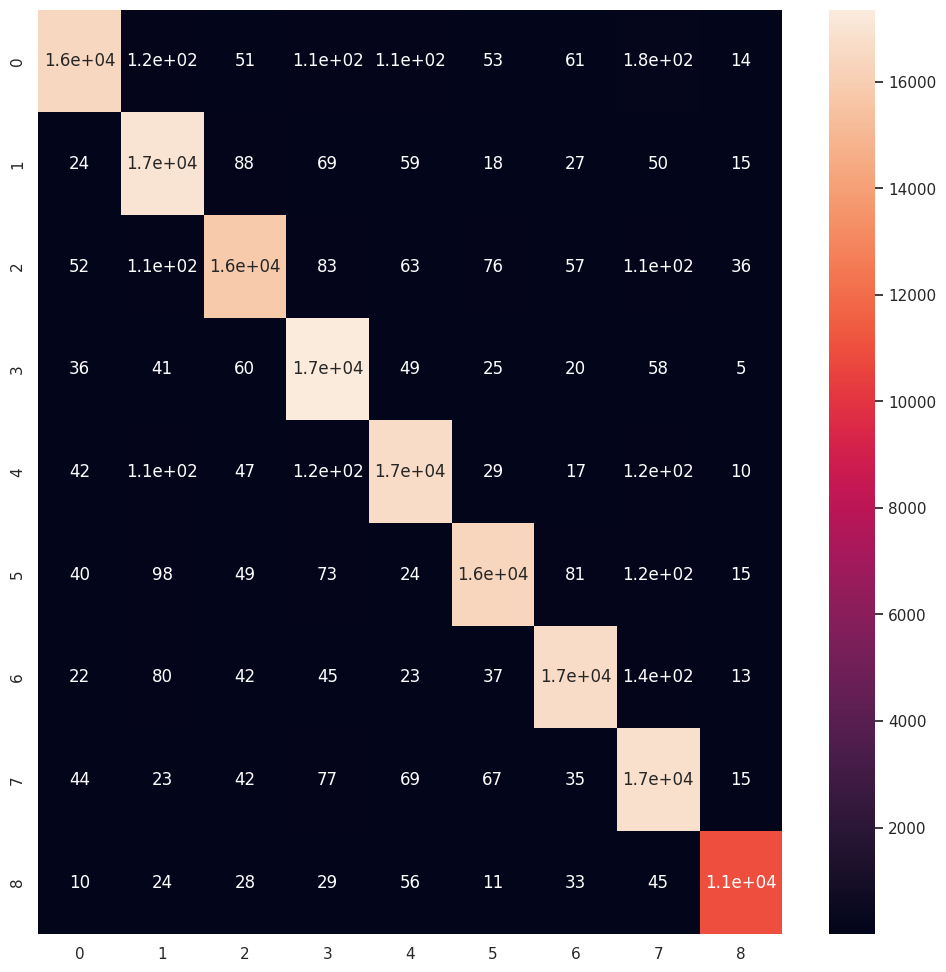

In [38]:
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize']=(12,12)
cf = confusion_matrix(y_test, pred)
sns.heatmap(cf, annot=True)

Можно сделать вывод, что модель больше всего путается между классами: 1 - 2, 1 - 5, 1- 6, 2 - 3, 5 - 6. В целом, видно, что 1 и 5 классы хуже отделяются.

## Отрисуем дерево модели

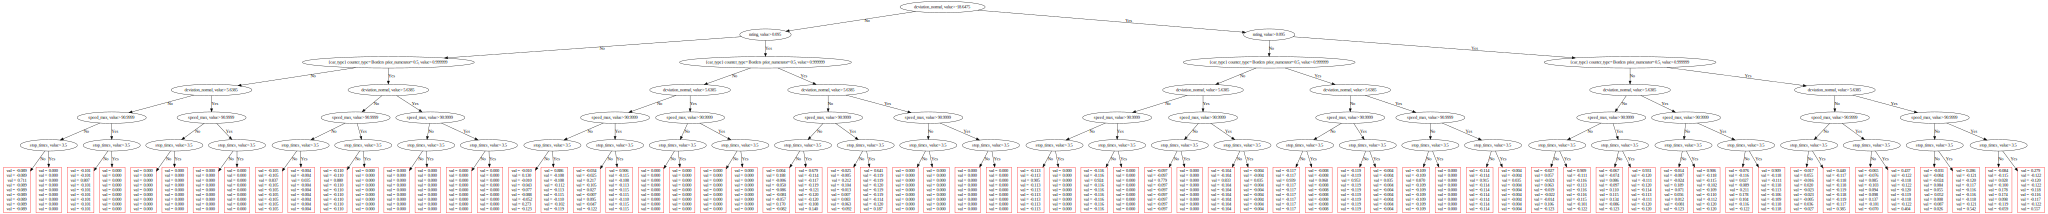

In [26]:
clf.plot_tree(
    tree_idx=0,
    pool=val_dataset
)

## <center> Partial plots </center>

 Посмотрим как топовые фичи влияют на прогноз модели

In [23]:
len(np.unique(y.values))

9

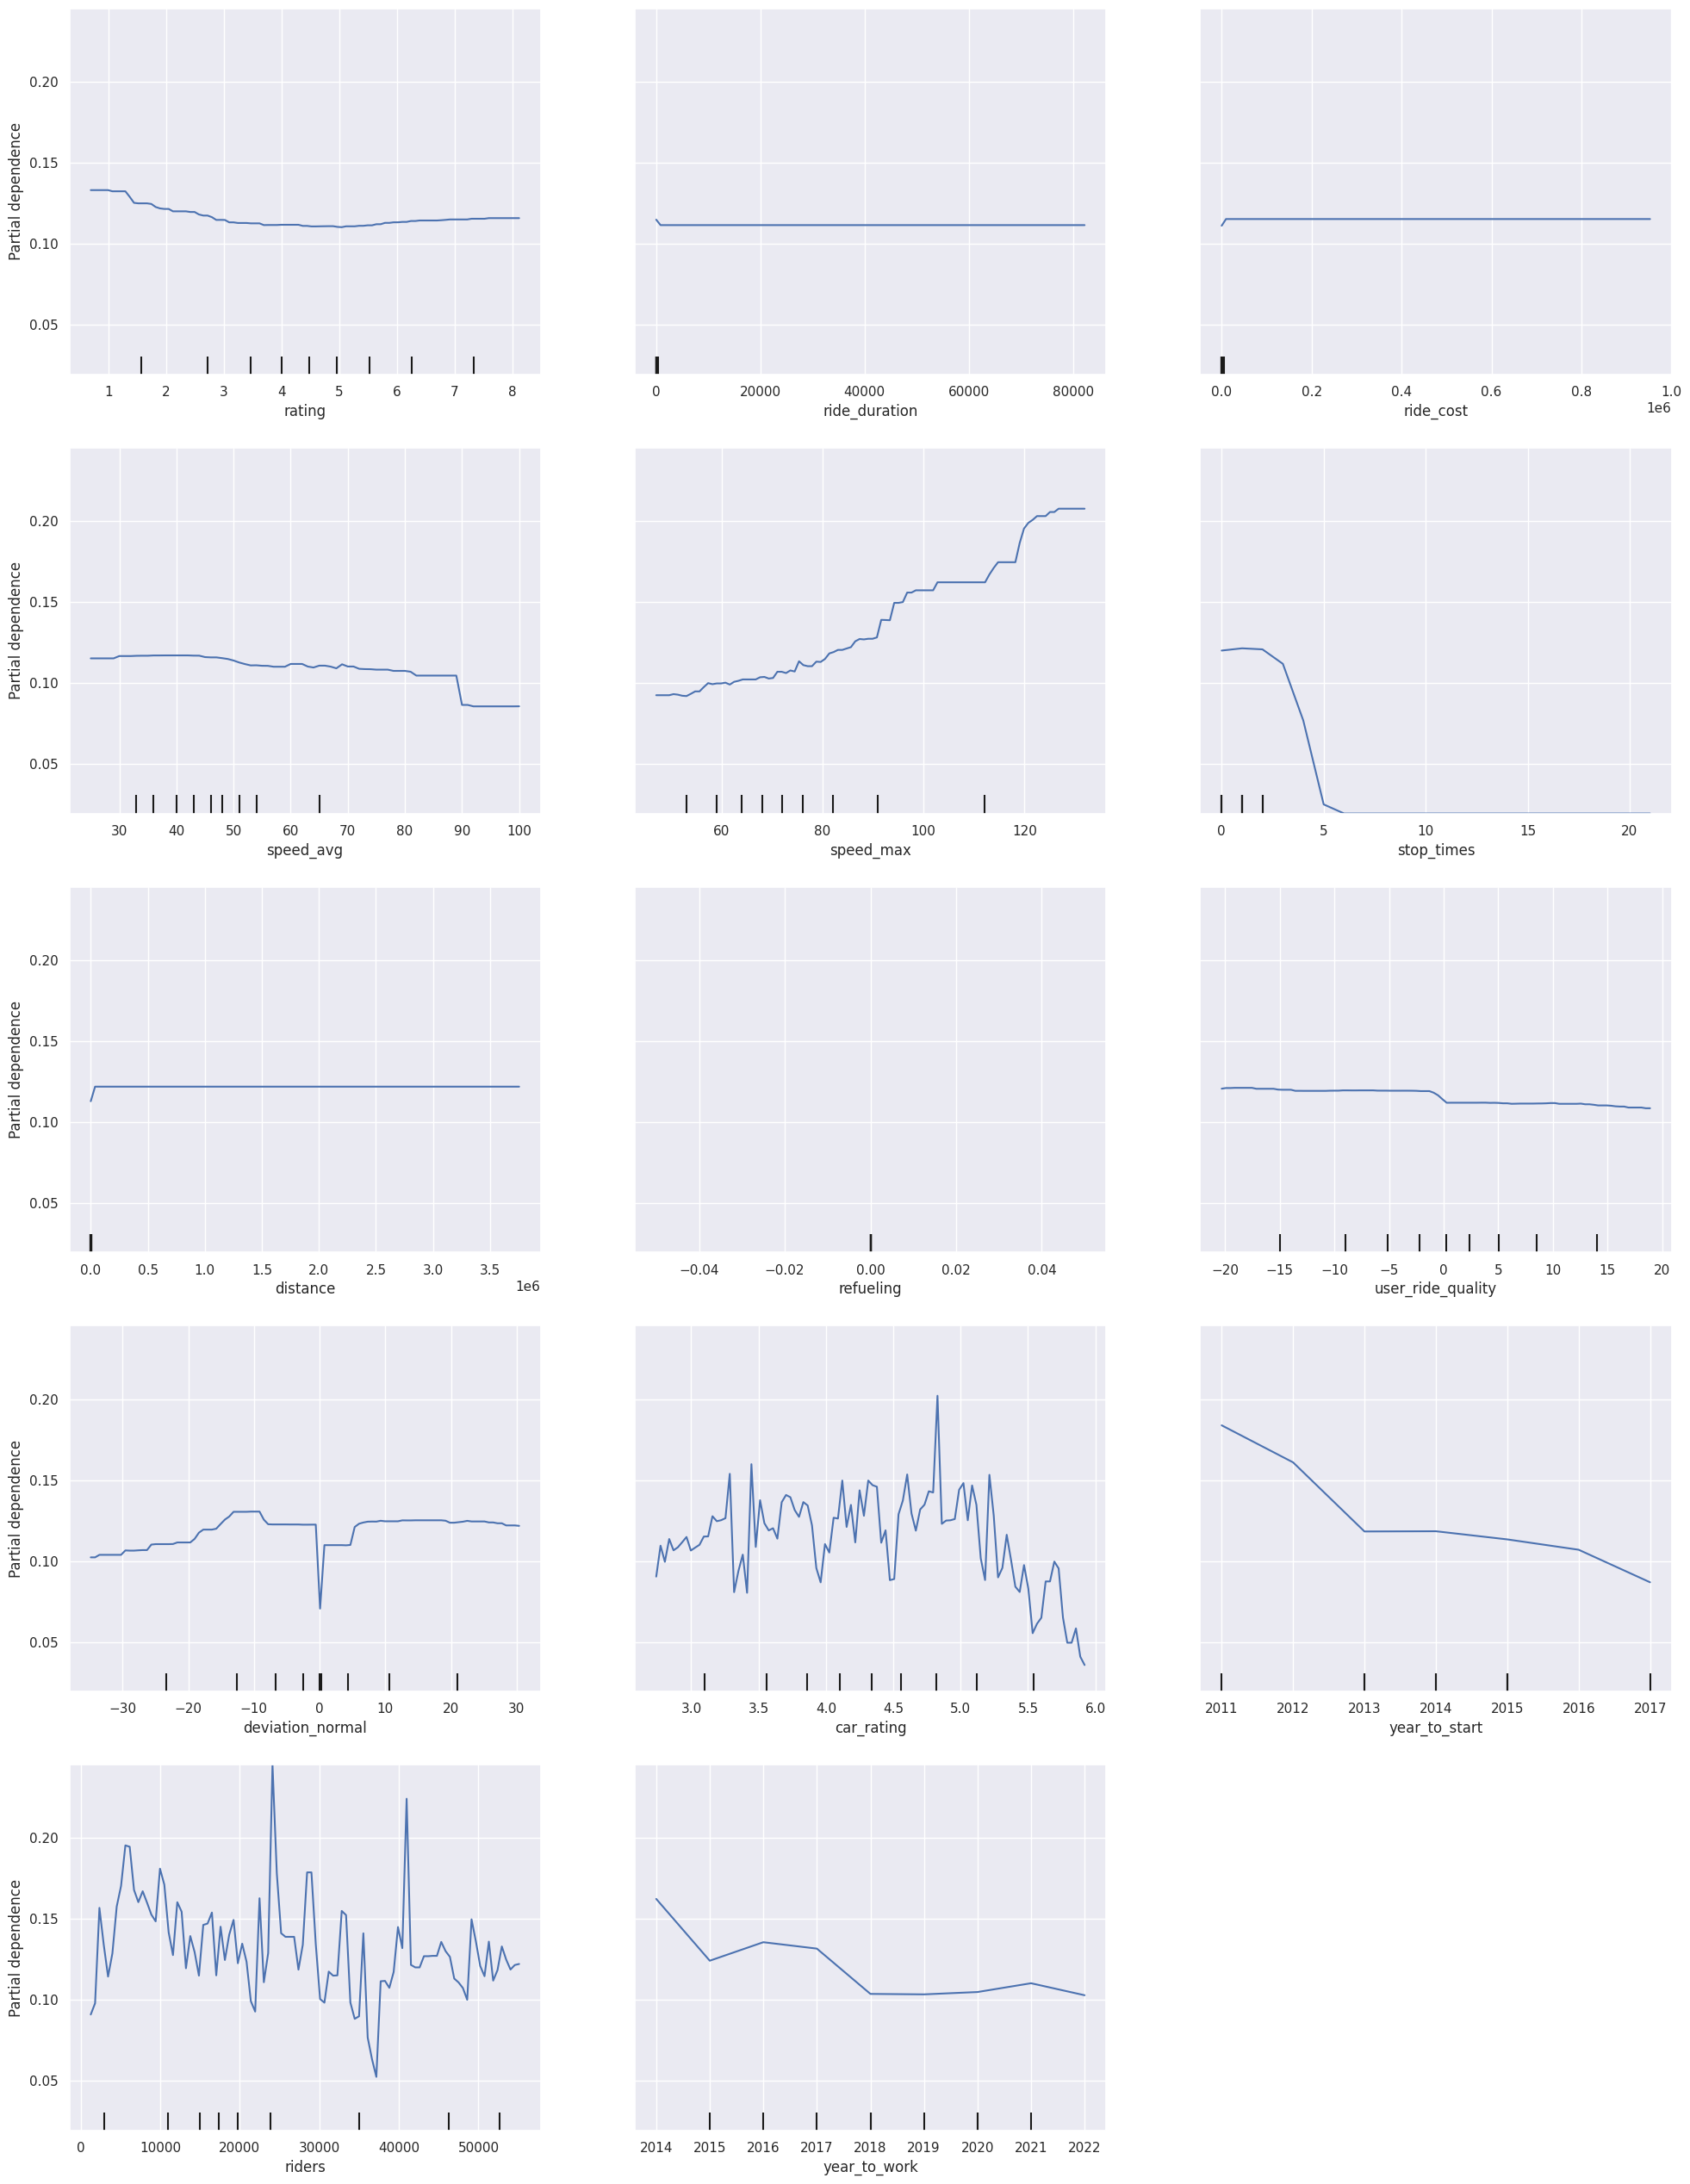

In [35]:
from sklearn.inspection import PartialDependenceDisplay

plt.rcParams['figure.figsize']=(24,32)
features = X.drop(cat_cols, axis=1).columns
PartialDependenceDisplay.from_estimator(clf, X_test, features, target='engine_overheat', n_cols=3,
    n_jobs=-1,
    random_state=42)

## Регрессия

In [31]:
X = rides_info.drop(drop_cols + ['target_1','target_2'], axis=1)
y = rides_info['target_1']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
regr = CatBoostRegressor(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                         )

In [34]:
regr.fit( X_train, y_train, 
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(regr.get_best_score())

Learning rate set to 0.138709
0:	learn: 2550478.9088986	test: 2554550.1394651	best: 2554550.1394651 (0)	total: 59.3ms	remaining: 59.3s
50:	learn: 2294575.4051264	test: 2290071.2895285	best: 2290071.2895285 (50)	total: 2.23s	remaining: 41.5s
100:	learn: 2165316.2203513	test: 2156972.0005641	best: 2156972.0005641 (100)	total: 4.48s	remaining: 39.9s
150:	learn: 2049908.3792736	test: 2041729.6189106	best: 2041729.6189106 (150)	total: 6.81s	remaining: 38.3s
200:	learn: 1953053.5067068	test: 1946433.6355833	best: 1946433.6355833 (200)	total: 9.07s	remaining: 36s
250:	learn: 1862253.2303781	test: 1855290.0276441	best: 1855290.0276441 (250)	total: 11.4s	remaining: 34.1s
300:	learn: 1780784.5106066	test: 1774198.8834812	best: 1774198.8834812 (300)	total: 13.8s	remaining: 32s
350:	learn: 1708413.4800225	test: 1702314.0897137	best: 1702314.0897137 (350)	total: 16.1s	remaining: 29.8s
400:	learn: 1643863.2270308	test: 1637877.9152138	best: 1637877.9152138 (400)	total: 18.4s	remaining: 27.4s
450:	le

`df.plot( )` - функция предоставляющая весь функционал библиотеки Matplotlib, так же можно через точку указывать конкретный тип желаемого графика, например: `df.plot.bar( )` или `df.plot.scatter( )`. На наш взгляд, пользоваться ей не очень удобно, поэтому не будем на ней останавливаться, подробнее можно ознакомиться в документации. Сразу перейдем к более продвинутым инструментам!

# <center> seaborn - это все что вам надо!</center> 

---------------------------
* ✅ sns.lineplot()
* ✅ sns.scatterplot()
* ❌ sns.relplot() = sns.lineplot() + sns.scatterplot() + стероиды
---------------------------
* ✅ sns.pairplot()
* ✅ sns.heatmap()
------------------------------
* ❌ sns.kdeplot()
* ❌ sns.ecdfplot()
* ❌ sns.histplot() 
* ✅ sns.displot() = sns.histplot()  + kdeplot() + ecdfplot()+ стероиды
-----------------------------
* ❌ sns.boxplot()
* ✅ sns.catplot() = sns.boxplot() + стероиды
----------------------------
* ✅ sns.jointplot()

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()

In [6]:
rides_info = pd.read_csv('../data/rides_info.csv')#.drop(['car_rating'], axis=1)
car_info = pd.read_csv('../data/car_info.csv')[['car_id','target_1', 'target_2']]
rides_info = rides_info.merge(car_info, on = 'car_id', how = 'left')
rides_info.head()      

user_id      car_id ride_id   ride_date  rating  ride_duration  \
0  I13186944D  A-1068587k     o1A  2020-01-01    3.51          80238   
1  R97784496t  A-1068587k     F1X  2020-01-01    5.72         105756   
2  I13694599a  A-1068587k     f1j  2020-01-02    5.57              5   
3  T93834217S  A-1068587k     Q1u  2020-01-02    4.52             46   
4  J40497939H  A-1068587k     C1X  2020-01-03    7.12             39   

   ride_cost  speed_avg  speed_max  stop_times      distance  refueling  \
0    1043089         38  52.000000           3  3.128016e+06          0   
1    1480577         45  64.000000           0  4.864626e+06          0   
2         60         73  93.602158           0  4.176389e+02          0   
3        640         45  62.000000           0  2.122785e+03          0   
4        306         39  58.000000           1  1.261300e+03          0   

   user_ride_quality  deviation_normal      target_1      target_2  
0          -0.302421              -0.0  2.638329e+06  engine_check  
1          -0.499172              -0.0  2.638329e+06  engine_check  
2          -1.548536              -5.0  2.638329e+06  engine_check  
3          -1.010666              -0.0  2.638329e+06  engine_check  
4          -0.940802              -0.0  2.638329e+06  engine_check

<center><b> sns.lineplot()</b></center> 

<code>lineplot</code> строит обычный линейный график

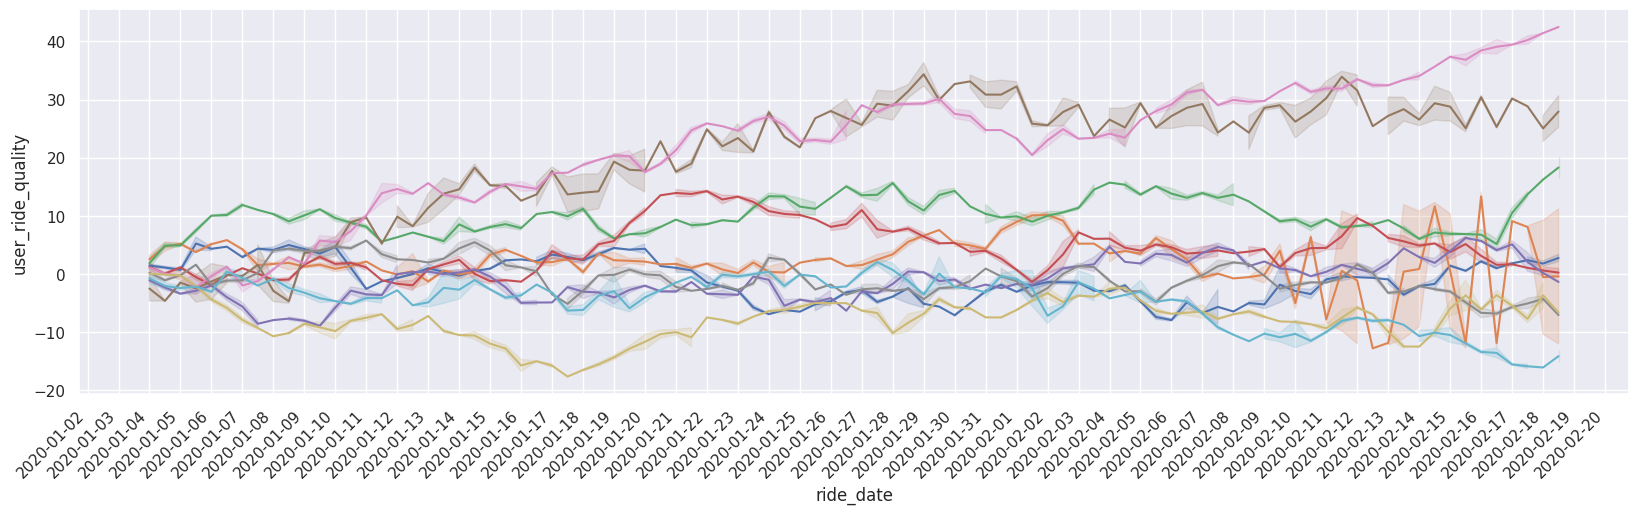

In [7]:
# Как растет качество поездки со временем на 10 автомобилях
plt.figure(figsize=(20, 5))

tmp = rides_info[rides_info['car_id'].isin(rides_info.sample(1000).car_id.unique()[:10])]
g = sns.lineplot(data = tmp, x = 'ride_date', y = 'user_ride_quality', hue='car_id', legend=False); 
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');
g.xaxis.set_major_locator(ticker.MultipleLocator(2))

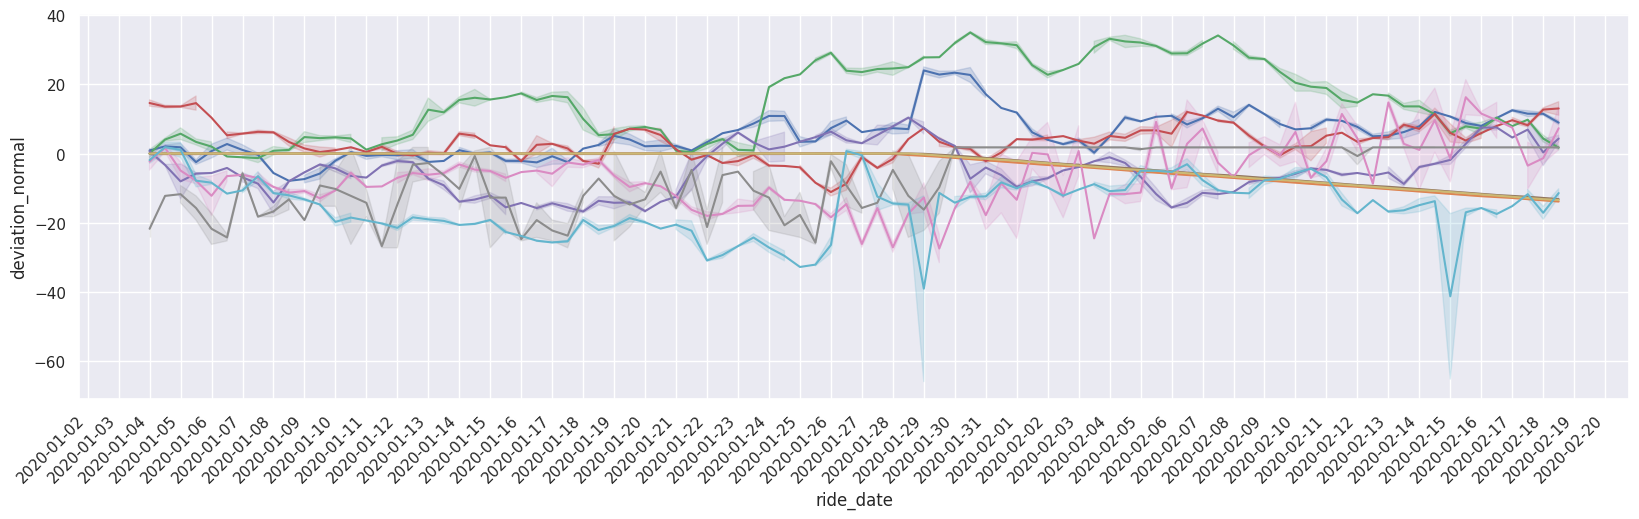

In [8]:
plt.figure(figsize=(20, 5))
tmp = rides_info[rides_info['car_id'].isin(rides_info.sample(100).car_id.unique()[:10])]
g = sns.lineplot(data = tmp, x = 'ride_date', y = 'deviation_normal', hue='car_id', legend=False); 

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');
g.xaxis.set_major_locator(ticker.MultipleLocator(2))

## <center>Диаграмма рассеяния</center>
<center><b> sns.scatterplot()</b></center> 
<center><b> Какого `hue='? )</b></center> 

Диаграмма рассеяния — это диаграмма, которая отображает точки на основе двух измерений набора данных.

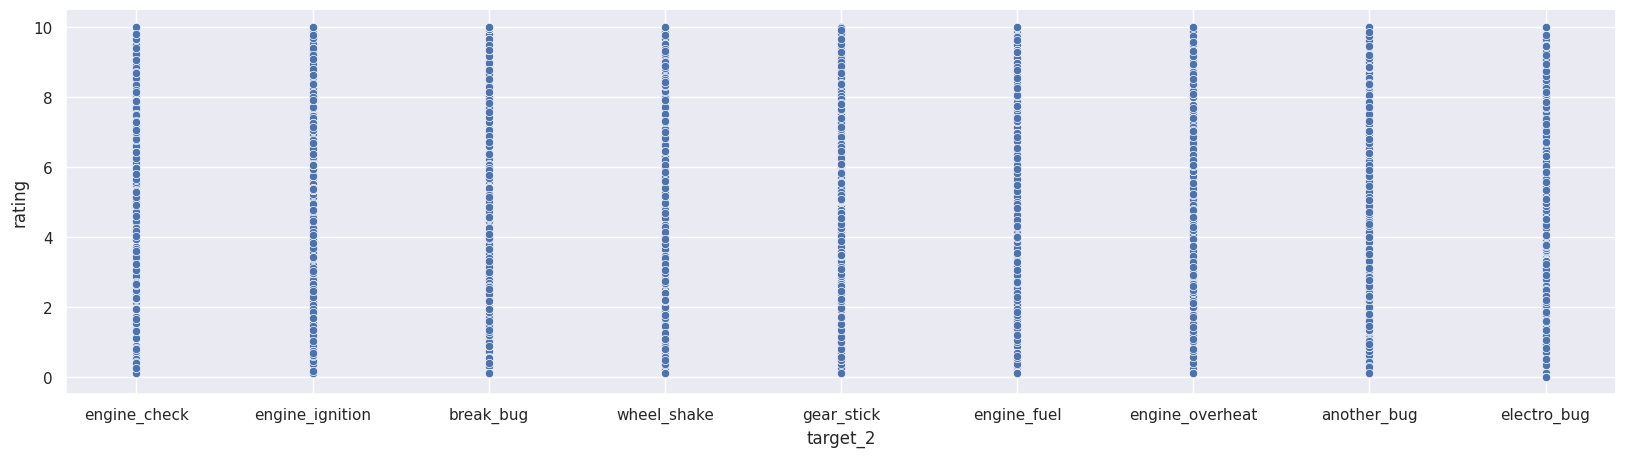

In [9]:
plt.figure(figsize=(20, 5))
sc = sns.scatterplot(data=rides_info, x="target_2", y="rating")

Чтобы было видно названия значений по оси X, повернем их на 45 градусов. <br>
Так же в параметр `hue` передадим название столбца для отображения распределения цветом. 

In [10]:
# Добавим пол водителя из таблицы rider_info и посмотрим как распределяется тип поломки в зависимости от пола
rider_info = pd.read_csv('../data/driver_info.csv')[['user_id', 'sex']]
tmp = rides_info.merge(rider_info, on = 'user_id', how = 'left')
# Передадим пол в параметр hue

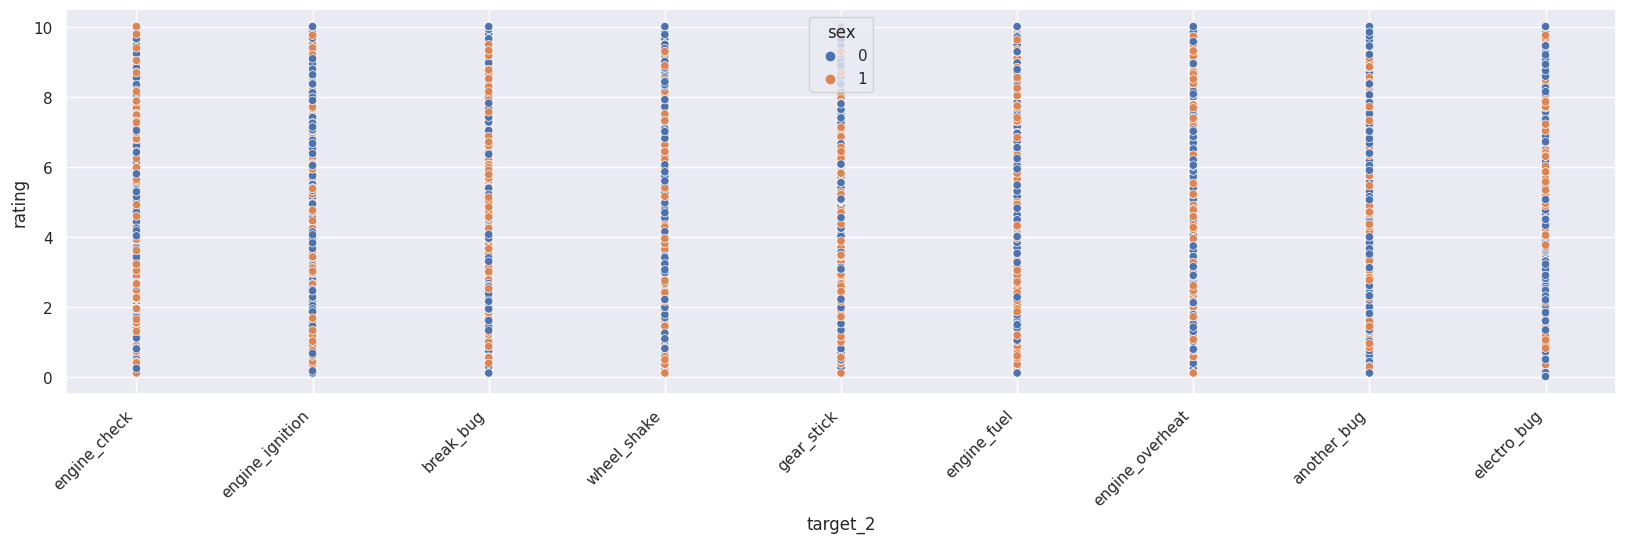

In [11]:
plt.figure(figsize=(20, 5))

sc = sns.scatterplot(data=tmp, x="target_2", y="rating", hue='sex')
sc.set_xticklabels(sc.get_xticklabels(),
                   rotation=45,
                   
                   horizontalalignment='right');

## <center> sns.relplot() = sns.scatterplot() + sns.lineplot() + стероиды</center> 

Функция `relplot()` объединяет в себе функционал `scatterplot()` и `lineplot()`, переключение происходит переключателем `kind`. <br>
Таким образом можно держать в голове меньше разных названий функций и параметров.

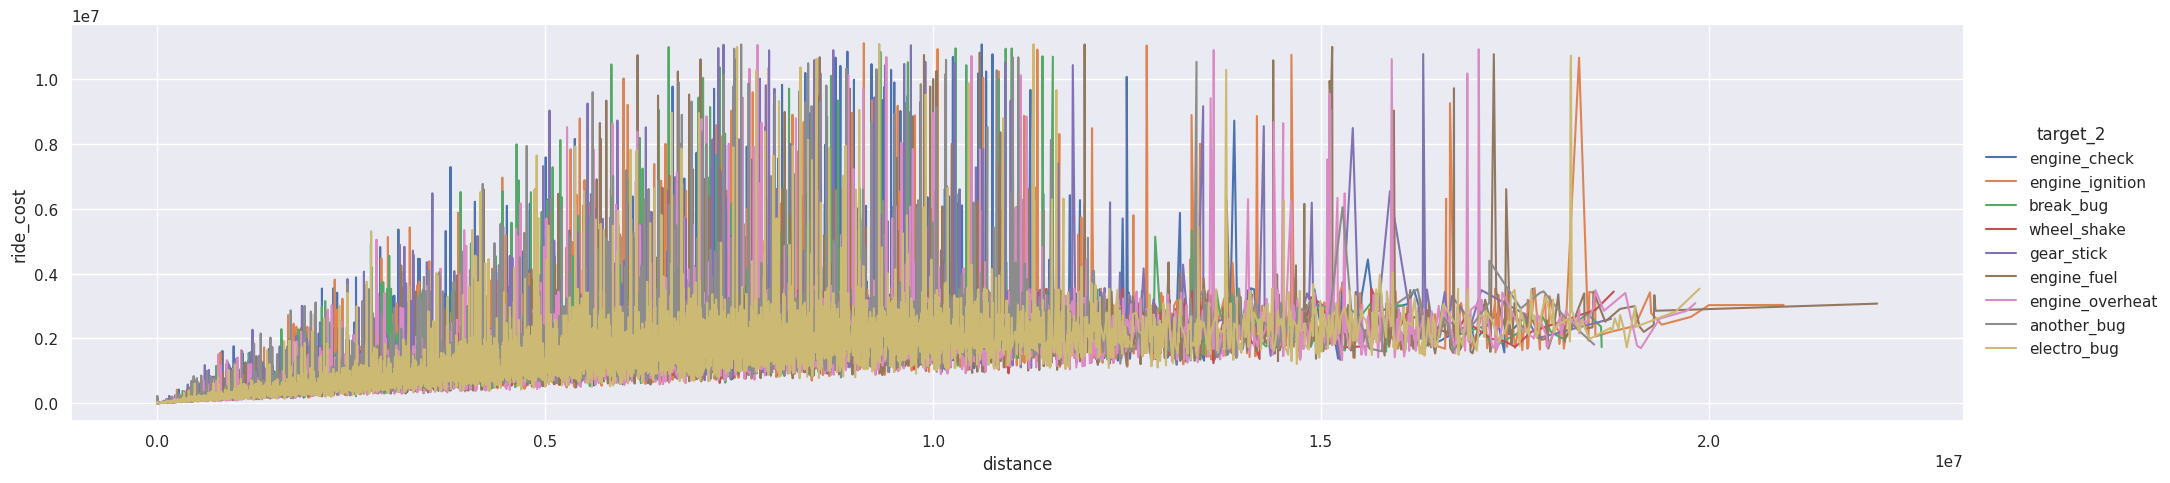

In [12]:
sns.relplot(data=rides_info,
            kind='line',
            x='distance',
            y='ride_cost',
            aspect = 4, 
            hue='target_2')

## <center>Построение распределений</center>
<center><b> sns.displot()</b></center>
<center><b>Переключатель <code>kind</code></b></center> 

 В Seaborn одна и таже функция  может применяться для построения разных графиков, но тип графика можно переключать в параметре `kind`

<Figure size 2000x500 with 0 Axes>

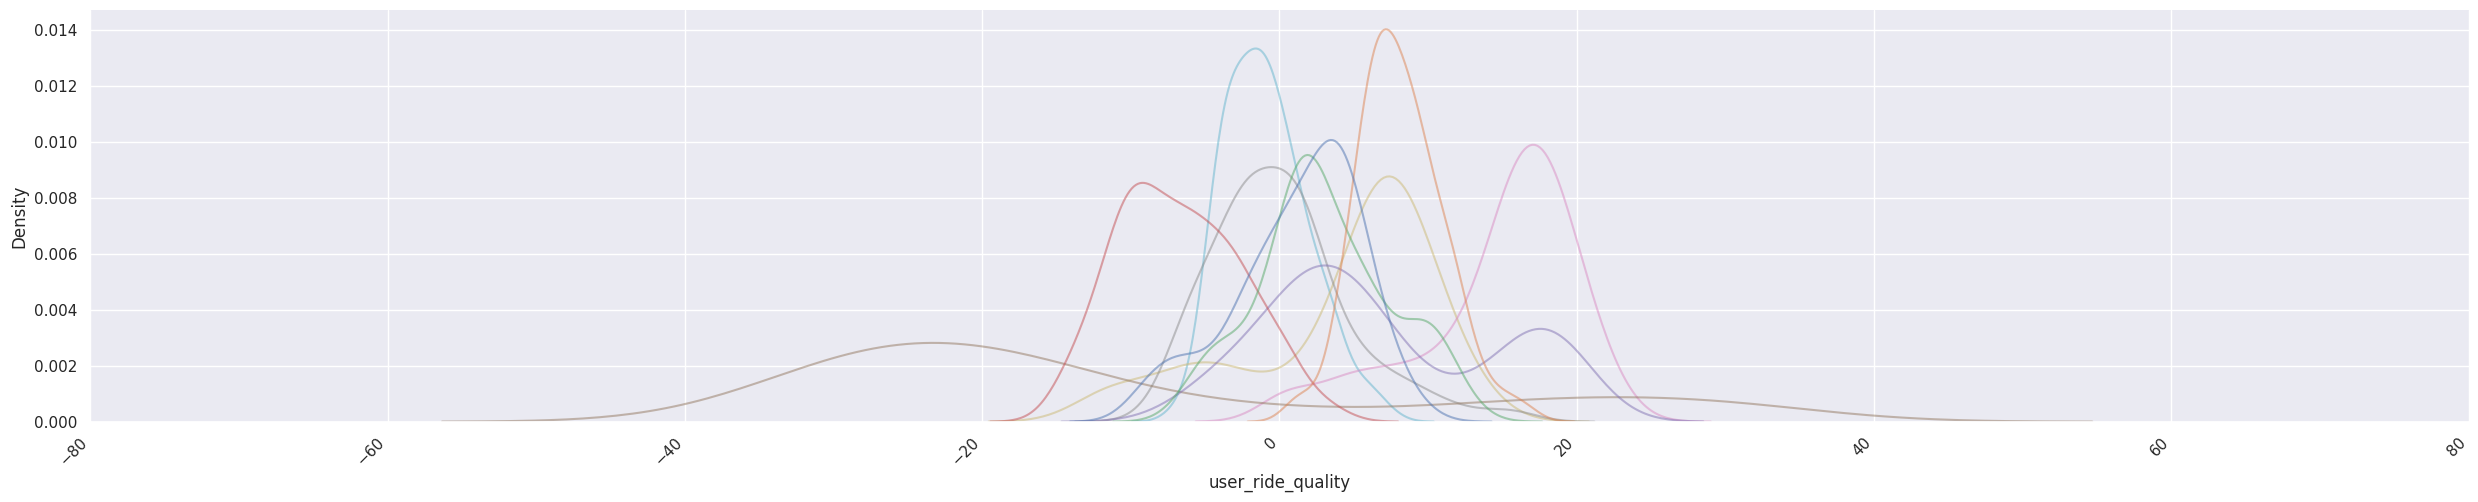

In [13]:
plt.figure(figsize=(20, 5))

tmp = rides_info[rides_info['car_id'].isin(rides_info.sample(100).car_id.unique()[:10])]
g = sns.displot(data = tmp, x= 'user_ride_quality', hue='car_id', legend=False, aspect = 5, kind = 'kde', alpha=0.5)
g.set_xticklabels(rotation=45, horizontalalignment='right');

<Figure size 2000x500 with 0 Axes>

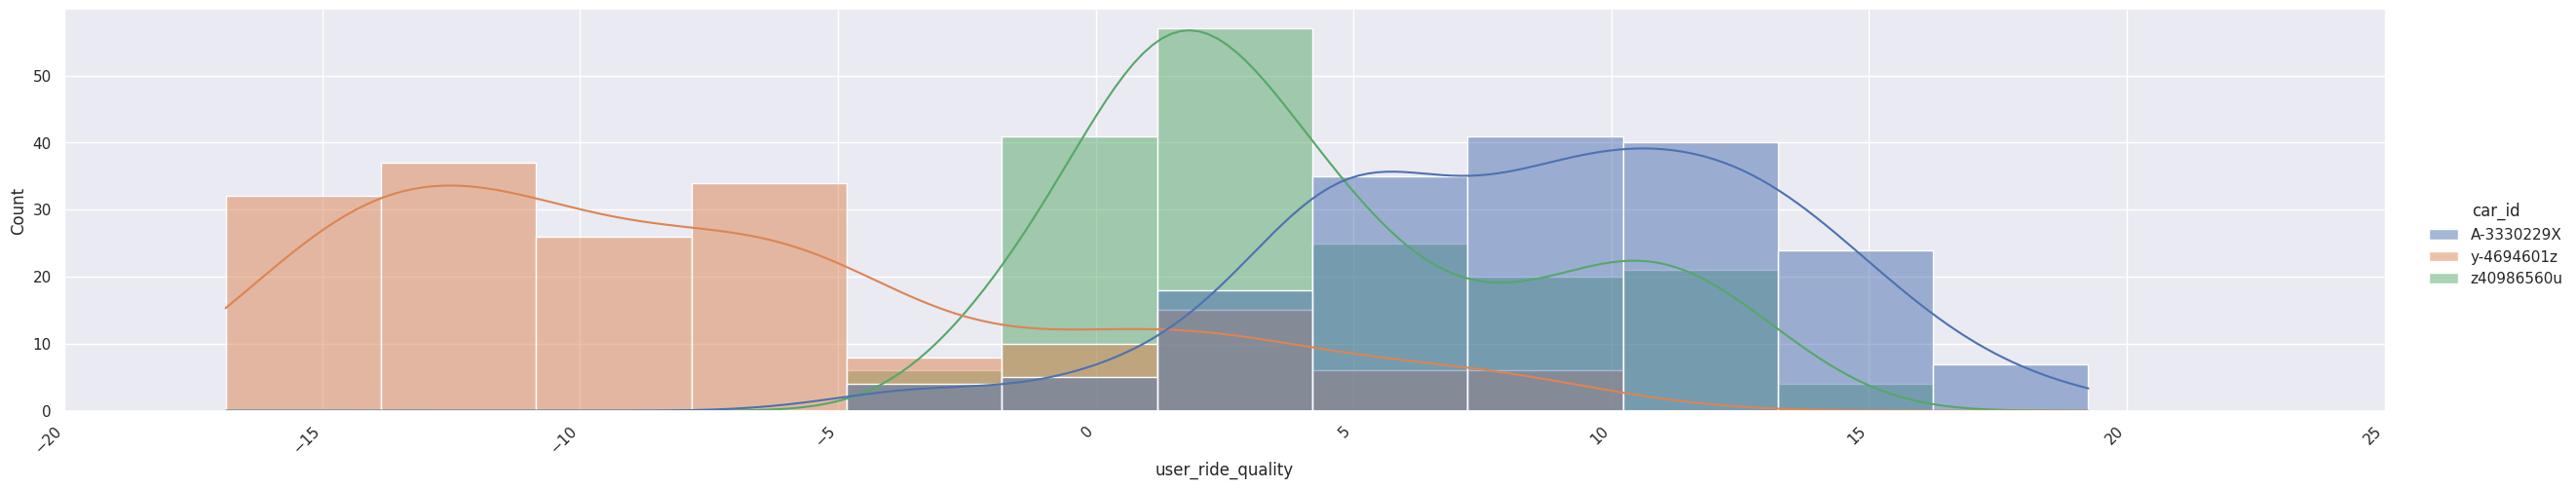

In [14]:
# Поменяем kind на hist и построим гистограмму
plt.figure(figsize=(20, 5))

tmp = rides_info[rides_info['car_id'].isin(rides_info.sample(100).car_id.unique()[:3])]
g = sns.displot(data = tmp, x= 'user_ride_quality', legend=True, aspect = 5, kind = 'hist', alpha=0.5, kde=True, hue='car_id')
g.set_xticklabels(rotation=45, horizontalalignment='right');

In [15]:
plt.figure(figsize=(25, 20))
tmp = rides_info[rides_info['car_id'].isin(rides_info.sample(100).car_id.unique()[:3])]

<Figure size 2500x2000 with 0 Axes>

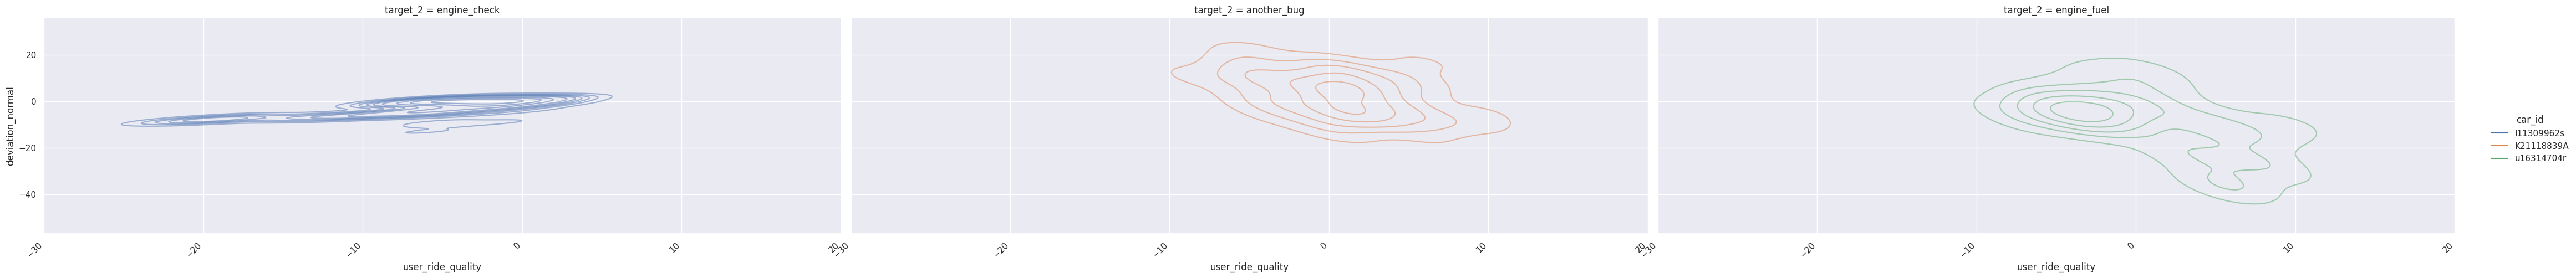

In [16]:
g = sns.displot(data = tmp, x= 'user_ride_quality',
                y='deviation_normal', legend=True,
                aspect = 3, kind = 'kde',
                alpha=0.5,
                hue='car_id',
                col='target_2'
               ).set_xticklabels(rotation=45, horizontalalignment='right');

## <center>Категориальные данные</center>
<center><b> sns.catplot()</b></center> 

In [17]:
# Добавим категориальный признак тип машины из car_info
car_info = pd.read_csv('../data/car_info.csv')[['car_id','car_type']]
temp_info = rides_info.merge(car_info, on = 'car_id', how = 'left')

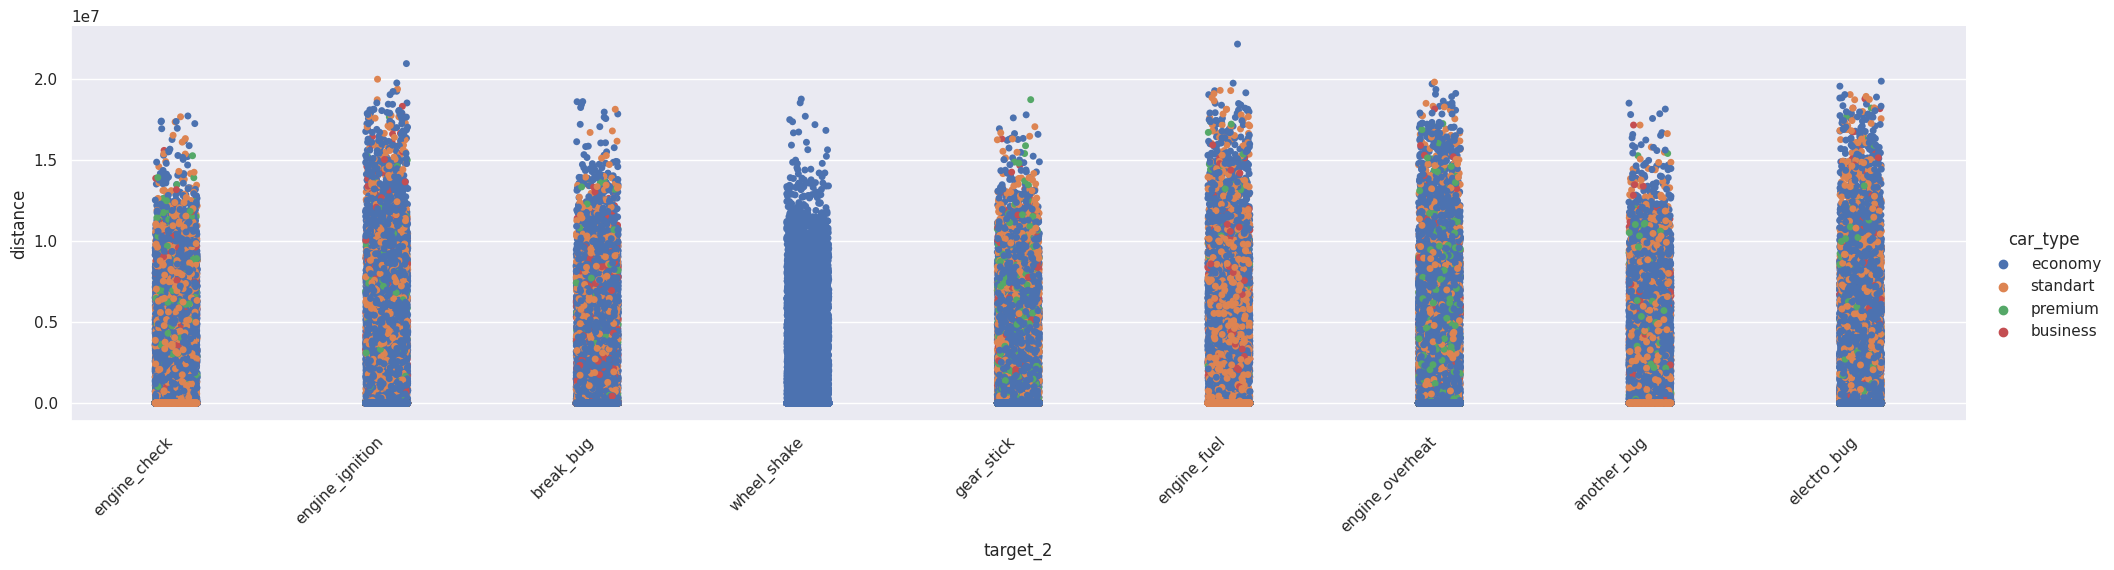

In [18]:
sns.catplot(data=temp_info,
            x='target_2',
            y='distance',
            aspect = 4,
            hue='car_type').set_xticklabels(rotation=45, horizontalalignment='right')

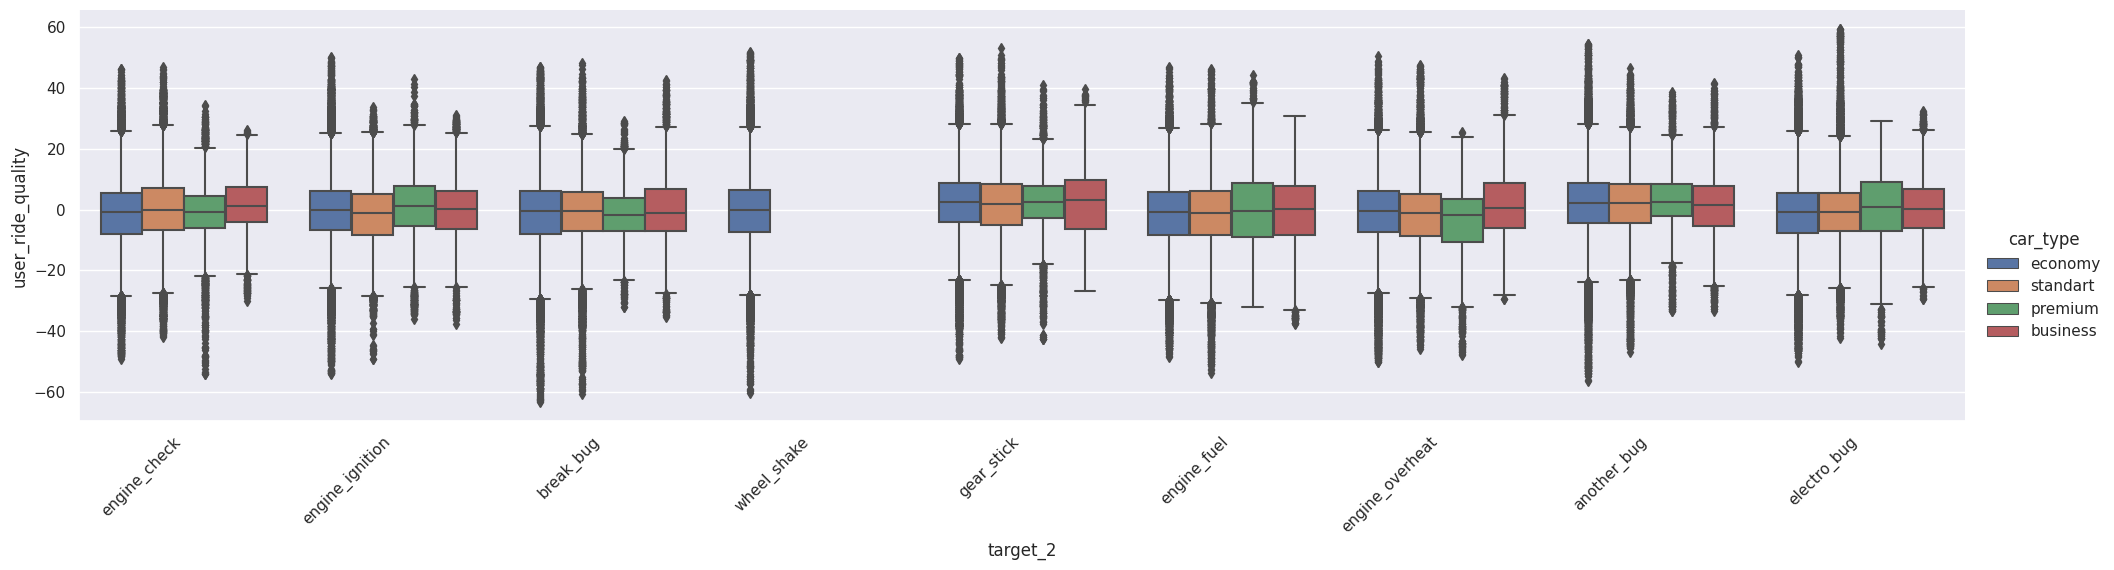

In [19]:
# Передадими в параметр kind=box, получим ящики с усами
sns.catplot(data=temp_info, 
            x='target_2',
            y='user_ride_quality',
            hue='car_type',
            aspect = 4,
            kind='box').set_xticklabels(rotation=45, horizontalalignment='right')

## <center>Тепловая карта</center>
<center><b> sns.heatmap()</b></center> 

Функция `heatmap( )`  чаще всего используется для отрисовки наглядной матрицы корреляций признаков. Посмотрим как её построить на нашем датасете.

Сначала посмотрим матрицу корреляций, котрорую выводит pandas:

In [20]:
rides_info.corr()

rating  ride_duration  ride_cost  speed_avg  speed_max  \
rating             1.000000       0.001680   0.001484  -0.082391  -0.279872   
ride_duration      0.001680       1.000000   0.907591   0.002403   0.001835   
ride_cost          0.001484       0.907591   1.000000   0.002616   0.001272   
speed_avg         -0.082391       0.002403   0.002616   1.000000   0.616791   
speed_max         -0.279872       0.001835   0.001272   0.616791   1.000000   
stop_times        -0.054863       0.000689  -0.001343  -0.130280   0.027472   
distance          -0.003531       0.964629   0.875845   0.067556   0.041877   
refueling          0.000296      -0.000510  -0.000463   0.000519   0.000601   
user_ride_quality  0.004246       0.000150   0.000763  -0.012726  -0.015377   
deviation_normal  -0.041939       0.001398   0.000219   0.036523   0.067104   
target_1          -0.034070      -0.005509   0.003832   0.026475   0.030818   

                   stop_times  distance  refueling  user_ride_quality  \
rating              -0.054863 -0.003531   0.000296           0.004246   
ride_duration        0.000689  0.964629  -0.000510           0.000150   
ride_cost           -0.001343  0.875845  -0.000463           0.000763   
speed_avg           -0.130280  0.067556   0.000519          -0.012726   
speed_max            0.027472  0.041877   0.000601          -0.015377   
stop_times           1.000000 -0.009178   0.005109           0.023067   
distance            -0.009178  1.000000  -0.000491          -0.000693   
refueling            0.005109 -0.000491   1.000000           0.000409   
user_ride_quality    0.023067 -0.000693   0.000409           1.000000   
deviation_normal     0.005017  0.003282   0.001080          -0.017211   
target_1            -0.059483 -0.004353  -0.000563          -0.005589   

                   deviation_normal  target_1  
rating                    -0.041939 -0.034070  
ride_duration              0.001398 -0.005509  
ride_cost                  0.000219  0.003832  
speed_avg                  0.036523  0.026475  
speed_max                  0.067104  0.030818  
stop_times                 0.005017 -0.059483  
distance                   0.003282 -0.004353  
refueling                  0.001080 -0.000563  
user_ride_quality         -0.017211 -0.005589  
deviation_normal           1.000000  0.138547  
target_1                   0.138547  1.000000

Можно ориентироваться, но достаточно сложно при большом количестве признаков. <br>
Теперь отрисуем матрицу с помощью `heatmap( )`:

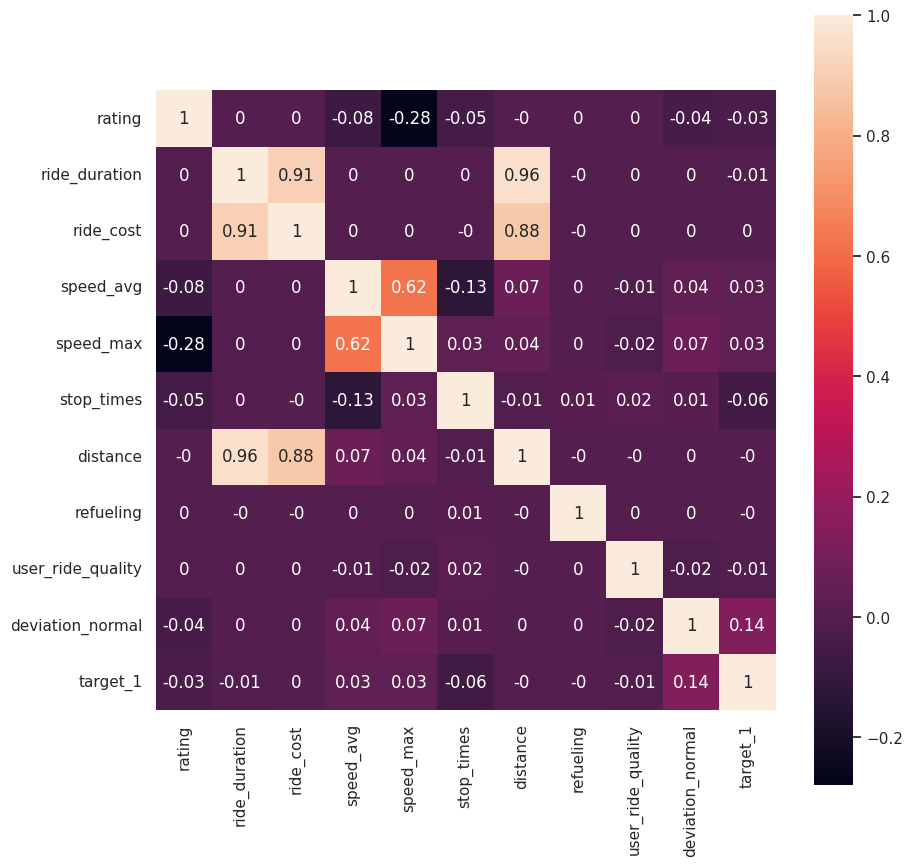

In [21]:
plt.rcParams['figure.figsize']=(10,10)
sns.heatmap(rides_info.corr().round(2), square=True, annot=True);

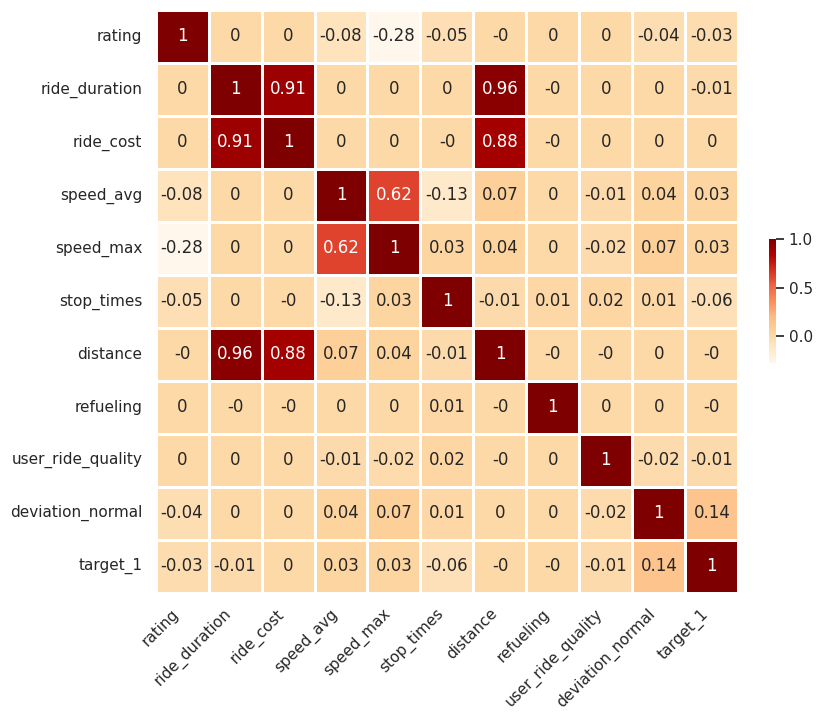

In [22]:
# Добавим красоты
colormap = sns.color_palette("Blues")
plt.rcParams['figure.figsize']=(8, 10)

g = sns.heatmap(rides_info.corr().round(2),
            annot=True,
            square = True,
            cmap='OrRd', # use orange/red colour map
            cbar_kws={'fraction' : 0.01}, # shrink colour bar
            linewidth=1, # space between cells
            ); 

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

Видно, что части снизу и сверху от диагонали идентичны, и новой инфомации не несут, создавая визуальный шум - уберем одну из них

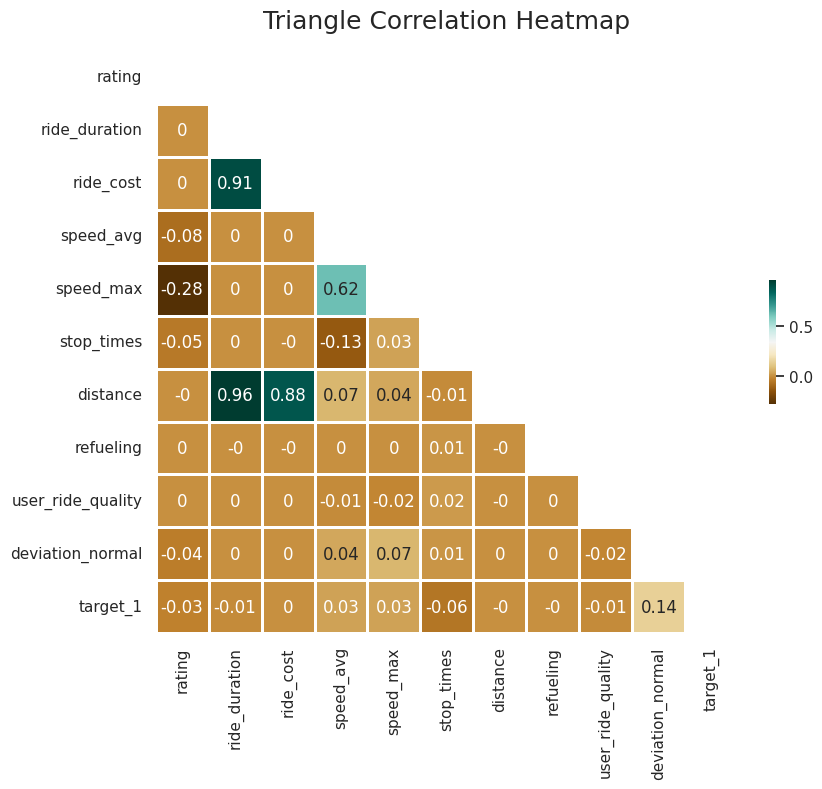

In [23]:
# Воспользуемся функциями np.triu, чтобы изолировать верхний треугольник (np.tril нижний)
# функция np.ones_like() изменит все изолированные значения на 1.
sns.set_style("whitegrid")
mask = np.triu(np.ones_like(rides_info.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(rides_info.corr().round(2), mask=mask, annot=True, square = True, cmap='BrBG',cbar_kws={'fraction' : 0.01}, linewidth=1) 
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

<center><b> sns.pairplot()</b></center> 

In [ ]:
sns.pairplot(rides_info)

In [ ]:
tmp = rides_info[['rating', 'distance', 'speed_max', 'target_2']]
sns.pairplot(tmp, hue='target_2')

## <center><b> Композиция нескольких видов графиков</b></center> 
<center><b> sns.jointplot()</b></center> 

In [ ]:
# Диаграмма рассеяния + распределения
sns.jointplot(x = "target_1", y = 'rating', data = rides_info, kind = 'reg')

In [ ]:
sns.jointplot(x = "target_1", y = 'rating', hue='target_2', data = rides_info, kind='scatter')